In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [7]:
# --- 1. Load and Merge Data ---

# Load data
# train_transaction = pd.read_csv('../input/train_transaction.csv')
# train_identity = pd.read_csv('../input/test_transaction.csv')
train_transaction = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
# X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
# y_check = train_df['isFraud']

In [8]:
train_df = train_df.sort_values('TransactionDT')

# 2. Calculate Cutoff Points
n_total = len(train_df)
idx_train_end = int(n_total * 0.70)      # End of first 70%
idx_val_end   = int(n_total * 0.85)      # End of next 15% (70+15=85)

In [9]:
# 3. Slice the Dataframe
# .iloc works by position [start : end]
train_set = train_df.iloc[ :idx_train_end]              # 0% to 70%
val_set   = train_df.iloc[idx_train_end : idx_val_end]  # 70% to 85%
test_set  = train_df.iloc[idx_val_end: ]                # 85% to 100%

In [10]:
cols_to_drop = ['isFraud', 'TransactionID', 'TransactionDT']

# TRAIN
X_train = train_set.drop(cols_to_drop, axis=1)
y_train = train_set['isFraud']

# VALIDATION
X_val = val_set.drop(cols_to_drop, axis=1)
y_val = val_set['isFraud']

# TEST (The Hold-out)
X_test = test_set.drop(cols_to_drop, axis=1)
y_test = test_set['isFraud']

In [11]:
missing_threshold = 0.80

missing_series = X_train.isnull().mean()
drop_cols = missing_series[missing_series > missing_threshold].index
print(f"Dropping {len(drop_cols)} columns with > {missing_threshold:.0%} missing values.")

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean   = X_val.drop(columns=drop_cols)
X_test_clean  = X_test.drop(columns=drop_cols)

Dropping 74 columns with > 80% missing values.


In [12]:
X_xgb = X_train_clean.copy()

print("Encoding categorical columns for XGBoost...")
for col in X_xgb.select_dtypes(include=['object']).columns:
    X_xgb[col] = X_xgb[col].astype('category').cat.codes

# 2. Configure & Train XGBoost
# We use 'hist' tree method because it's extremely fast
clf = XGBClassifier(
    n_estimators=100,       # 100 trees is enough for feature selection
    max_depth=10,           # Deep trees to find complex fraud patterns
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,         # Critical: Tells XGBoost to handle NaNs automatically
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    tree_method='hist'      # Fast training mode
)

print("Training XGBoost to find the most important features...")
clf.fit(X_xgb, y_train)

Encoding categorical columns for XGBoost...
Training XGBoost to find the most important features...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

--- Top 50 Features Selected ---
['V258', 'C1', 'C14', 'card2', 'C13', 'card1', 'TransactionAmt', 'V294', 'addr1', 'D2']


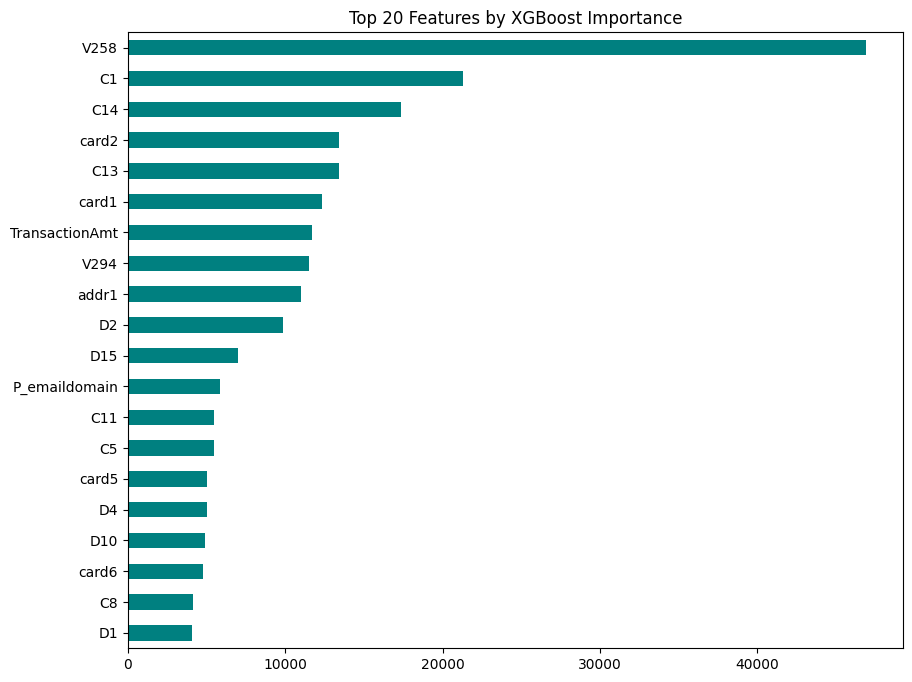

In [13]:
importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain'))

# 2. Sort and Take Top 50
TOP_N = 50
best_features = importances.sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"--- Top {TOP_N} Features Selected ---")
print(best_features[:10])  # Print top 10 to check

# 3. Visualize
plt.figure(figsize=(10, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [14]:
FINAL_CAT_COLS = []
FINAL_NUM_COLS = []

print("classifying Top Features...")

for col in best_features:
    # A. Is it an Object (String) in the original cleaned data?
    if X_train_clean[col].dtype == 'object':
        FINAL_CAT_COLS.append(col)
        
    # B. Is it a Number but behaves like a Category? (Few unique values)
    # Example: 'card4' might be 1, 2, 3, 4. Treat as Category.
    elif X_train_clean[col].nunique() < 20:
        FINAL_CAT_COLS.append(col)
        
    # C. Otherwise, it is a Number (Amount, Time, Distance)
    else:
        FINAL_NUM_COLS.append(col)

print(f"--------------------------------")
print(f"Feature Split for Neural Network:")
print(f" - Categorical (Embeddings): {len(FINAL_CAT_COLS)}")
print(f" - Numerical (Scaled):       {len(FINAL_NUM_COLS)}")
print(f"--------------------------------")

# Finalize the Datasets
# We now discard all other columns and keep only the winners
X_train_ready = X_train_clean[best_features].copy()
X_val_ready   = X_val_clean[best_features].copy()
X_test_ready  = X_test_clean[best_features].copy()

classifying Top Features...
--------------------------------
Feature Split for Neural Network:
 - Categorical (Embeddings): 11
 - Numerical (Scaled):       39
--------------------------------


In [15]:
# 1. Setup the 3 datasets (Fresh copies)
# We use the 'ready' sets (Top 50 features) you created earlier
X_xgb_train = X_train_ready.copy()
X_xgb_val   = X_val_ready.copy()
X_xgb_test  = X_test_ready.copy()

print("Preparing data for XGBoost...")

# 2. Encode Categoricals (Text -> Number)
# XGBoost can't read "Visa", so we turn it into numbers.
# We do NOT need to scale numbers or fill missing values.
for col in FINAL_CAT_COLS:
    # Combine to ensure same encoding across all sets
    temp_all = pd.concat([X_xgb_train[col], X_xgb_val[col], X_xgb_test[col]])
    
    # Fit the encoder
    le = LabelEncoder()
    le.fit(temp_all.astype(str))
    
    # Transform each set
    X_xgb_train[col] = le.transform(X_xgb_train[col].astype(str))
    X_xgb_val[col]   = le.transform(X_xgb_val[col].astype(str))
    X_xgb_test[col]  = le.transform(X_xgb_test[col].astype(str))

print("✅ Data Ready. (Notice: No scaling or mean-filling needed!)")

Preparing data for XGBoost...
✅ Data Ready. (Notice: No scaling or mean-filling needed!)


In [18]:
# 1. Calculate Class Weight (For Imbalance)
# XGBoost uses 'scale_pos_weight' = count(neg) / count(pos)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Fraud Imbalance Ratio: {ratio:.2f}")

# 2. Build the Model
clf = XGBClassifier(
    n_estimators=2000,        # Max epochs (high, because we stop early)
    learning_rate=0.02,       # Slow & careful learning
    max_depth=10,             # Deep trees for complex fraud patterns
    subsample=0.8,            # Use 80% of rows per tree
    colsample_bytree=0.8,     # Use 80% of columns per tree
    scale_pos_weight=ratio,   # Handle the imbalance
    missing=np.nan,           # Handle missing values automatically
    eval_metric='auc',        # Optimize for AUC
    tree_method='hist',       # Fast mode
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50 # Stop if validation score doesn't improve for 50 rounds
)

# 3. Train with Early Stopping
print("\nStarting XGBoost Training...")
clf.fit(
    X_xgb_train, y_train,
    # This is the "Validation" step
    eval_set=[(X_xgb_train, y_train), (X_xgb_val, y_val)],
    verbose=50                # Print progress every 50 rounds
)

Fraud Imbalance Ratio: 27.43

Starting XGBoost Training...
[0]	validation_0-auc:0.89057	validation_1-auc:0.82434
[50]	validation_0-auc:0.93762	validation_1-auc:0.88614
[100]	validation_0-auc:0.95260	validation_1-auc:0.89579
[150]	validation_0-auc:0.96498	validation_1-auc:0.90441
[200]	validation_0-auc:0.97228	validation_1-auc:0.90948
[250]	validation_0-auc:0.97776	validation_1-auc:0.91363
[300]	validation_0-auc:0.98249	validation_1-auc:0.91549
[350]	validation_0-auc:0.98603	validation_1-auc:0.91659
[400]	validation_0-auc:0.98876	validation_1-auc:0.91726
[450]	validation_0-auc:0.99103	validation_1-auc:0.91741
[496]	validation_0-auc:0.99249	validation_1-auc:0.91679


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [19]:
from sklearn.metrics import roc_auc_score

print("------------------------------------------------")
print("Evaluating XGBoost on TEST Set...")

# 1. Predict (Probabilities)
xgb_preds = clf.predict_proba(X_xgb_test)[:, 1]

# 2. Score
xgb_auc = roc_auc_score(y_test, xgb_preds)

print(f"🏆 XGBoost FINAL TEST ROC-AUC: {xgb_auc:.5f}")
print("------------------------------------------------")

------------------------------------------------
Evaluating XGBoost on TEST Set...
🏆 XGBoost FINAL TEST ROC-AUC: 0.88840
------------------------------------------------
